In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import sys
import json
import importnb
import matplotlib.pyplot as plt
import PIL
import wandb

with __import__("importnb").Notebook():
    from model import VisionTransformer

In [2]:
notebook_path = os.getcwd()
parent_dir = os.path.dirname(notebook_path)
sys.path.append(parent_dir)

In [ ]:
key = input("input_API_key:")

In [4]:
if wandb.login(key=key):
    print("already logined")

wandb: Currently logged in as: shun-kato (odango_team). Use `wandb login --relogin` to force relogin


already logined


In [5]:
run = wandb.init(
    # このrunがログに記録されるプロジェクトを設定
    project="isogawa-tutorial",
    name="ViT_CIFAR10_epoch10",
    # ハイパーパラメーターとrunのメタデータをトラッキング
    config={
        "learning_rate": 0.001,
        "epochs": 10,
        "optimizer": "adam",
    },
    reinit=True,
    notes="datasets:CIFAR10,model:ViT:16")

## 各パラメータの指定

In [6]:
batch_size = 16
num_head = 12
d_model = 768
d_ff = 2048
N = 12
dropout_rate = 0.1
layer_norm_eps = 1e-5
out_dim = 10
patch_size = 16
epoch = 2

In [7]:
image_size = (224,224)
num_channels = 3
patch_dim = num_channels * patch_size**2
patch_num = (image_size[0]//patch_size) * (image_size[0]//patch_size)

In [8]:
print(patch_dim)

768


In [9]:
print(patch_num)

196


## Datasetの読み込み、DataLoaderへの変形
---
### 参考
https://zenn.dev/ynakashi/articles/d78810f7457c56

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16,
                                          shuffle=True)

test_data = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16,
                                          shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## 辞書の読み込み

### 一応データセットの確認　

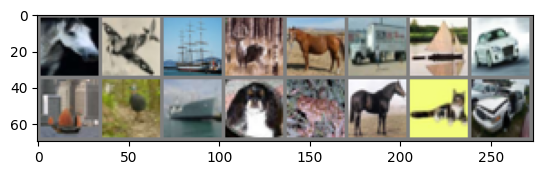

horse plane  ship  deer horse truck  ship   car  ship  bird  ship   dog  frog horse   cat   car


In [12]:
def imshow(img):  # 画像の表示関数
    img = img / 2 + 0.5     # 正規化を戻す
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 適当な訓練セットの画像を取得
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 画像の表示
imshow(torchvision.utils.make_grid(images))
# ラベルの表示
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## モデルの読み込み

In [14]:
model = VisionTransformer(
    d_model=d_model,
    d_ff=d_ff,
    num_head=num_head,
    patch_size=patch_size,
    patch_num=patch_num,
    patch_dim=patch_dim,
    out_dim=out_dim,
    N=N,
).to(device)

## 損失関数と最適化関数の定義

In [15]:
from torch import optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99), eps=1e-9)

In [16]:
wandb.watch(model, criterion, log="all", log_freq=10)

[]

In [22]:
from tqdm import tqdm

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for i in range(epoch):
  print('---------------------')
  print("Epoch:{}/{}".format(i+1,epoch))

  train_loss = 0
  train_accuracy = 0
  test_loss = 0
  test_accuracy = 0

  model.train()

  for batch in tqdm(train_loader):
    optimizer.zero_grad()

    inputs,labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    pred = model(inputs)
    loss = criterion(pred,labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    pred_label = torch.max(pred,1)[1]
    train_accuracy += torch.sum(pred_label==labels).item()/len(labels)
  train_loss = train_loss/len(train_loader)
  train_accuracy = train_accuracy/len(train_loader)
  train_loss_list.append(train_loss)
  train_acc_list.append(train_accuracy)
  print("train_loss = {}".format(train_loss))
  print("train_acc = {}".format(train_accuracy))
  model.eval()
  with torch.no_grad():
    for batch in tqdm(test_loader):
      inputs,labels = batch
      inputs = inputs.to(device)
      labels = labels.to(device)
      pred = model(inputs)
      loss = criterion(pred,labels)
      test_loss += loss.item()
      pred_label = torch.max(pred,1)[1]
      test_accuracy += torch.sum(pred_label==labels).item()/len(labels)
    test_loss = test_loss/len(test_loader)
    test_accuracy = test_accuracy/len(test_loader)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_accuracy)
    print("test_loss = {}".format(test_loss))
    print("test_acc = {}".format(test_accuracy))
    wandb.log({"loss":train_loss, "acc":train_accuracy, "val_loss": test_loss, "val_acc":test_accuracy})
      

---------------------
Epoch:1/2


  0%|          | 12/3125 [00:18<1:19:25,  1.53s/it]


KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
sns.set(style="darkgrid")
palette = sns.color_palette("muted")
# グラフ1（リスト 'a' 用）
sns.lineplot(
    ax=axes[0],
    x=np.arange(len(train_loss_list)),
    y=train_loss_list,
    palette=palette,
    marker="o",
    linewidth=2.5,
)
axes[0].set_title("Train_loss/steps", fontsize=16, fontweight="bold")
axes[0].set_xlabel("Step", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)

sns.lineplot(
    ax=axes[1],
    x=np.arange(len(test_loss_list)),
    y=test_loss_list,
    palette=palette,
    marker="o",
    linewidth=2.5,
)
axes[1].set_title("Test_loss/steps", fontsize=16, fontweight="bold")
axes[1].set_xlabel("Step", fontsize=14)
axes[1].set_ylabel("Loss", fontsize=14)

# グラフの表示
plt.show()